- knn con vecinos cercanos considerando pickup and dropoff data
- knn con el respecto al día de la semana (finde o no)
    -- hacer esto con todos los datos temporales (lunes a viernes y sábado y domingo)
- distancia ==> sklearn.metrics.pairwise
    -- manhattan, euclidean, canberra, minkowski, cosine (Jere va a leer porque sí)

# Contexto

El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.
- **date**: fecha y hora.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

# Librerías

In [1]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import holidays
from geopy.distance import geodesic

# Carga del dataset



In [2]:
# Carga de datos del dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)


# Análisis exploratorio de datos

## Análisis descriptivo

In [20]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [21]:
# Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

-Variables numéricas: fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, droptoff_latitude, passenger_count.

-Variables categóricas: key, date, pickup_datetime, passenger_count.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [23]:
# Valores nulos
df.isna().sum()

,0
key,0
date,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [24]:
# Principales medidas descriptivas
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


## Análisis de datos atípicos

In [3]:
# Dropear filas donde el valor del viaje es nulo o negativo

df = df[df["fare_amount"].notna()]               # remove NaN / None
df = df[df["fare_amount"].astype(float) > 0]

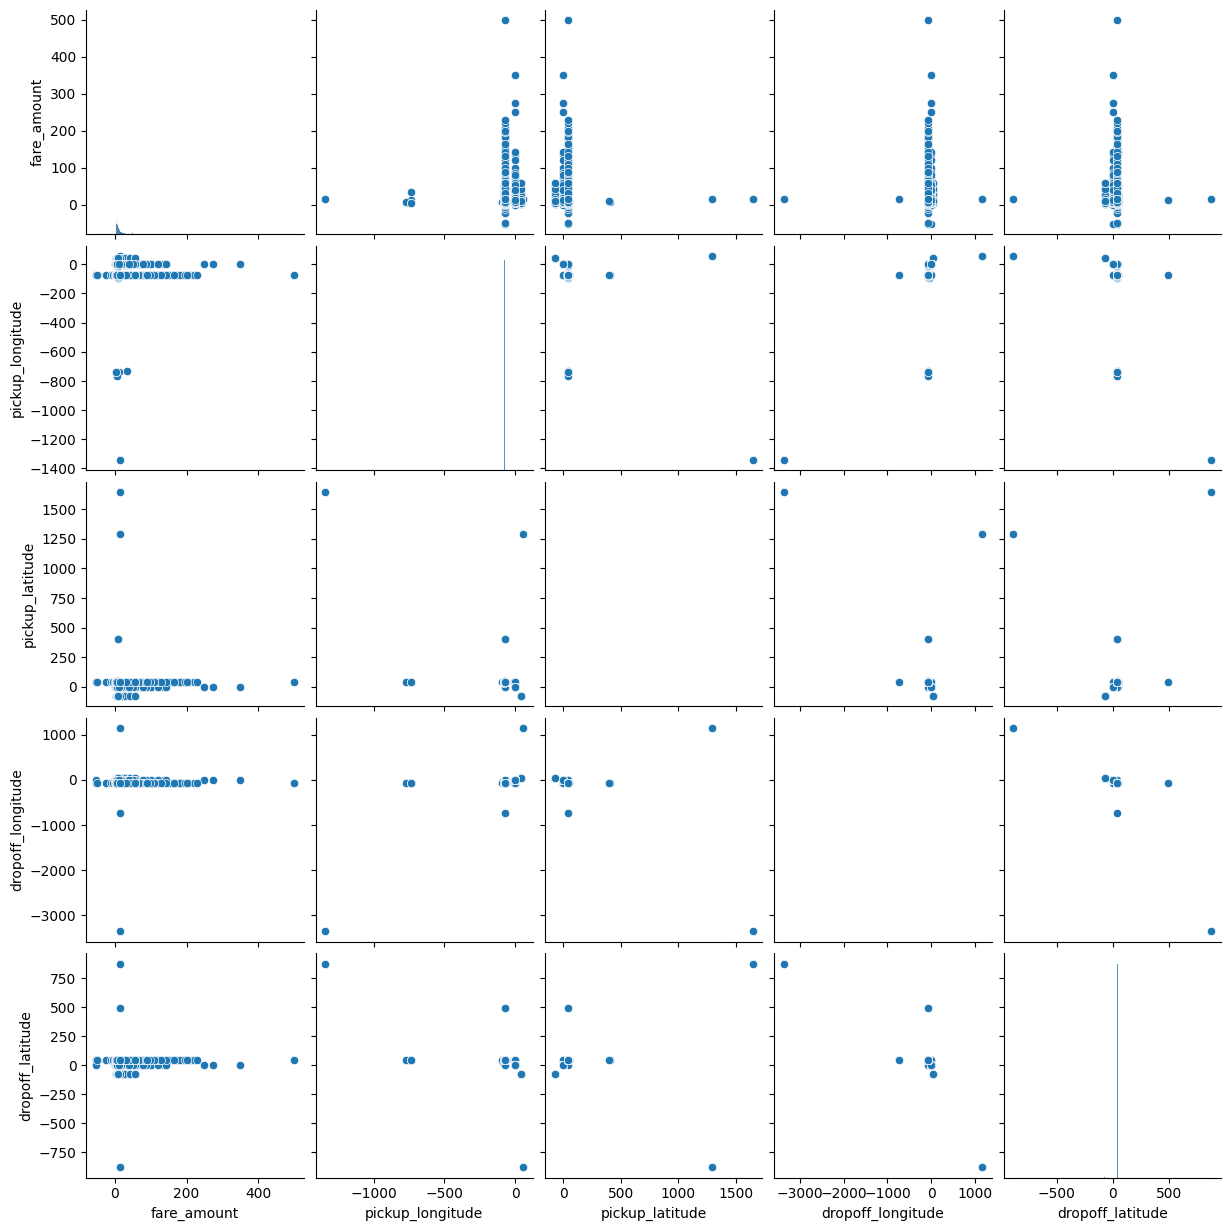

In [111]:
dfa = pd.read_csv(file_path)
cols = dfa.select_dtypes(include=['float64'])
sns.pairplot(cols)  # soporta 'hue' para colorear por categoría
plt.show()

In [4]:
# Cantidad de pasajeros/as
df.loc[(df['passenger_count'] < 0), 'passenger_count'] = 0
df.loc[(df['passenger_count'] > 6), 'passenger_count'] = 6

# Crear categorías para cantidad de pasajeros
def categorize_passengers(count):
    if count == 0:
        return 'delivery'
    elif 1 <= count <= 4:
        return 'normal'
    elif 5 <= count <= 6:
        return 'xl'

df['passenger_category'] = df['passenger_count'].apply(categorize_passengers)

# Crear dummies para las categorías
passenger_dummies = pd.get_dummies(df['passenger_category'], prefix='passenger', dtype=int, drop_first=True)
df = pd.concat([df, passenger_dummies], axis=1)

# Dropear columnas que no serán utilizadas
df.drop(columns=['passenger_category','passenger_count'], inplace=True)

In [5]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_delivery,passenger_normal,passenger_xl
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,0,1,0
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,0,1,0
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,0,1,0
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,0,1,0
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,0,0,1


In [6]:
# Separar datetime en date y time
df["dateTime"] = pd.to_datetime(df["pickup_datetime"]) # sin errors, ya que checkeamos que no hay valores nulos
df["dateTime"] = df["dateTime"].dt.tz_convert("America/New_York") # Esto cubre el horario de verano

df["time"] = df["dateTime"].dt.time
df["date"] = df["dateTime"].dt.date

In [7]:
# Codificación de ...
df["date"] = pd.to_datetime(df["date"])
df["weekday_num"] = df["date"].dt.dayofweek + 1

k = (2*math.pi)/7 # 7 por los días de la semana

df["sen_weekday_num"] = np.sin(k*df["weekday_num"])
df["cos_weekday_num"] = np.cos(k*df["weekday_num"])

In [8]:
# Traer feriados para validar si es fin de semana o feriado
us_holidays = holidays.US(state="NY")

df["weekend_or_holiday"] = ((df["weekday_num"] >= 6) | (df["date"].dt.date.isin(us_holidays))).astype(int)

In [9]:
# 1 a 7 ==> madrugada ==> V = 1  ==> CODIFICACIÓN BINARIA ==> 0 | 0
# 7 a 11 ==> mañana ==> V = 2 ==> CODIFICACIÓN BINARIA ==> 0 | 1
# 11 a 19 ==> tarde ==> V = 3 ==> CODIFICACIÓN BINARIA ==> 1 | 1
# 19 a 1 ==> noche ==> V = 4 ==> CODIFICACIÓN BINARIA ==> 1 | 0

df["time"] = df["dateTime"].dt.hour

df["bin_time_1"] = 0
df["bin_time_2"] = 0

df.loc[(df["time"] >= 7) & (df["time"] < 11), ["bin_time_1", "bin_time_2"]] = [0, 1]
df.loc[(df["time"] >= 11) & (df["time"] < 19), ["bin_time_1", "bin_time_2"]] = [1, 1]
df.loc[(df["time"] >= 19) | (df["time"] < 1), ["bin_time_1", "bin_time_2"]] = [1, 0]

In [10]:
# ...
k_week= 2*np.pi/52

df["week"] = df["date"].dt.isocalendar().week

df["sen_week_num"] = np.sin(k_week*df["week"])
df["cos_week_num"] = np.cos(k_week*df["week"])

In [11]:
# INVIERNO: de diciembre a febrero ==> CODIFICACIÓN BINARIA ==> 0 | 0
# PRIMAVERA: de marzo a mayo ==> CODIFICACIÓN BINARIA ==> 0 | 1
# VERANO: de junio a agosto ==> CODIFICACIÓN BINARIA ==> 1 | 1
# OTOÑO: de septiembre a noviembre ==> CODIFICACIÓN BINARIA ==> 1 | 0

df['month'] = df['date'].dt.month

df.loc[(df['month'] >= 3) & (df['month'] < 6), ["bin_month_1", "bin_month_2"]] = [0, 1]
df.loc[(df['month'] >= 6) & (df['month'] < 9), ["bin_month_1", "bin_month_2"]] = [1, 1]
df.loc[(df['month'] >= 9) & (df['month'] < 12), ["bin_month_1", "bin_month_2"]] = [1, 0]
df.loc[(df['month'] == 12) | (df['month'] < 3), ["bin_month_1", "bin_month_2"]] = [0, 0]

Official source

The NYC Department of City Planning (DCP) provides the NYC Borough Boundary shapefile (“nybb”) that defines the boundary clipped to the shoreline.
s-media.nyc.gov

The metadata for that dataset gives the bounding box of that official polygon: West −74.257159°, East −73.699215°, North 40.915568°, South 40.496010°

longitud ==> este oeste

latitud ==> norte sur

In [12]:
# Setear coordenadas inválidas a NaN
df.loc[df["pickup_latitude"] > 41, ["pickup_latitude"]] = np.nan
df.loc[df["pickup_latitude"] < 40, ["pickup_latitude"]] = np.nan
df.loc[df["dropoff_latitude"] > 41, ["dropoff_latitude"]] = np.nan
df.loc[df["dropoff_latitude"] < 40, ["dropoff_latitude"]] = np.nan

df.loc[df["pickup_longitude"] > -73.50, ["pickup_longitude"]] = np.nan
df.loc[df["pickup_longitude"] < -74, ["pickup_longitude"]] = np.nan
df.loc[df["dropoff_longitude"] > -73.50, ["dropoff_longitude"]] = np.nan
df.loc[df["dropoff_longitude"] < -74, ["dropoff_longitude"]] = np.nan

In [14]:
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_delivery', 'passenger_normal', 'passenger_xl', 'dateTime',
       'time', 'weekday_num', 'sen_weekday_num', 'cos_weekday_num',
       'weekend_or_holiday', 'bin_time_1', 'bin_time_2', 'week',
       'sen_week_num', 'cos_week_num', 'month', 'bin_month_1', 'bin_month_2'],
      dtype='object')

In [15]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_delivery,passenger_normal,...,cos_weekday_num,weekend_or_holiday,bin_time_1,bin_time_2,week,sen_week_num,cos_week_num,month,bin_month_1,bin_month_2
0,24238194,2015-05-07,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,0,1,...,-0.900969,0,1,1,19,0.748511,-0.663123,5,0.0,1.0
1,27835199,2009-07-17,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,0,1,...,-0.222521,0,1,1,29,-0.354605,-0.935016,7,1.0,1.0
2,44984355,2009-08-24,12.9,2009-08-24 21:45:00 UTC,NaN,40.740770,-73.962565,40.772647,0,1,...,0.623490,0,1,1,35,-0.885456,-0.464723,8,1.0,1.0
3,25894730,2009-06-26,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,0,1,...,-0.222521,0,0,0,26,0.0,-1.0,6,1.0,1.0
4,17610152,2014-08-28,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,0,0,...,-0.900969,0,1,1,35,-0.885456,-0.464723,8,1.0,1.0


In [17]:
df = df.drop(['key', 'date', 'pickup_datetime', 'dateTime', 'time', 'week', 'month', 'weekday_num'], axis=1)

In [25]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_delivery,passenger_normal,passenger_xl,sen_weekday_num,cos_weekday_num,weekend_or_holiday,bin_time_1,bin_time_2,sen_week_num,cos_week_num,bin_month_1,bin_month_2
0,7.5,-73.999817,40.738354,-73.999512,40.723217,0,1,0,-0.433884,-0.900969,0,1,1,0.748511,-0.663123,0.0,1.0
1,7.7,-73.994355,40.728225,-73.994710,40.750325,0,1,0,-0.974928,-0.222521,0,1,1,-0.354605,-0.935016,1.0,1.0
2,12.9,NaN,40.740770,-73.962565,40.772647,0,1,0,0.781831,0.623490,0,1,1,-0.885456,-0.464723,1.0,1.0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,0,1,0,-0.974928,-0.222521,0,0,0,0.0,-1.0,1.0,1.0
4,16.0,-73.925023,40.744085,-73.973082,40.761247,0,0,1,-0.433884,-0.900969,0,1,1,-0.885456,-0.464723,1.0,1.0


In [26]:
from sklearn.model_selection import train_test_split
import random

random.seed(0)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

cols_to_impute=['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'sen_weekday_num', 'cos_weekday_num', 'weekend_or_holiday', 'bin_time_1', 'bin_time_2']

imputer = KNNImputer(n_neighbors=10)
imputer.fit(train_df[cols_to_impute])

train_df_imputed = train_df.copy()
test_df_imputed = test_df.copy()

train_df_imputed[cols_to_impute] = imputer.transform(train_df_imputed[cols_to_impute])
test_df_imputed[cols_to_impute] = imputer.transform(test_df_imputed[cols_to_impute])

In [29]:
from haversine import haversine

train_df_imputed['distance_km'] = train_df_imputed.apply(
    lambda row: haversine(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ),
    axis=1
)

test_df_imputed['distance_km'] = test_df_imputed.apply(
    lambda row: haversine(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ),
    axis=1
)

In [99]:
mean_distance = train_df_imputed.query("distance_km != 0")['distance_km'].mean()
print(mean_distance)


3.2042913547106195


In [100]:
train_df_imputed.loc[train_df_imputed['distance_km'] == 0, 'distance_km'] = mean_distance
test_df_imputed.loc[test_df_imputed['distance_km'] == 0, 'distance_km'] = mean_distance

In [101]:
train_df_imputed[train_df_imputed['distance_km'] == 0]
test_df_imputed[test_df_imputed['distance_km'] == 0]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_delivery,passenger_normal,passenger_xl,sen_weekday_num,cos_weekday_num,weekend_or_holiday,bin_time_1,bin_time_2,sen_week_num,cos_week_num,bin_month_1,bin_month_2,distance_km


In [102]:
x_train = train_df_imputed.drop(['fare_amount'], axis = 1).copy()
y_train = train_df_imputed[['fare_amount']].copy()

x_test = test_df_imputed.drop(['fare_amount'], axis = 1).copy()
y_test = test_df_imputed[['fare_amount']].copy()

# x_train_imputed = x_train.copy()
# x_test_imputed = x_test.copy()

# # Aplicar el imputador en ambos conjuntos (entrenamiento y prueba)

x_train = x_train.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'], axis=1)
x_test = x_test.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'], axis=1)


In [103]:
x_train.columns

Index(['passenger_delivery', 'passenger_normal', 'passenger_xl',
       'sen_weekday_num', 'cos_weekday_num', 'weekend_or_holiday',
       'bin_time_1', 'bin_time_2', 'sen_week_num', 'cos_week_num',
       'bin_month_1', 'bin_month_2', 'distance_km'],
      dtype='object')

In [112]:
x_train = x_train.drop(['passenger_delivery'], axis=1)
x_test = x_test.drop(['passenger_delivery'], axis=1)

In [113]:
x_train = x_train.drop(['sen_week_num', 'cos_week_num'], axis=1)
x_test = x_test.drop(['sen_week_num', 'cos_week_num'], axis=1)

In [104]:
# Modelo de regresión lineal
linear_model = LinearRegression()
# Entrenamiento del modelo
linear_model.fit(x_train, y_train)
# Predicciones en el conjunto de prueba
y_pred = linear_model.predict(x_test)

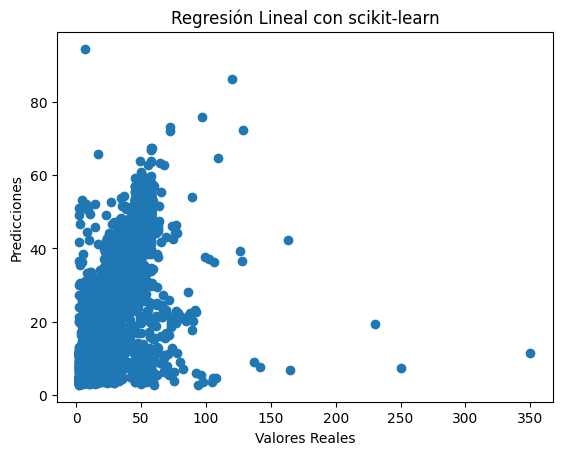

In [105]:
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Regresión Lineal con scikit-learn")
plt.show()

In [106]:
# Métricas del modelo
mse_selfeat = mean_squared_error(y_test, y_pred)
r2_selfeat = r2_score(y_test, y_pred)
score_selfeat = linear_model.score(x_test, y_test)
score_selfeat_train = linear_model.score(x_train, y_train)
print(f"Puntaje train: {score_selfeat_train}")
print(f"Puntaje test: {score_selfeat}")

print(f'Error cuadrático medio (MSE) con features seleccionadas: {mse_selfeat:.2f}')
print(f'Coeficiente de determinación (R^2) con features seleccionadas: {r2_selfeat:.2f}\n')

Puntaje train: 0.6459112238943485
Puntaje test: 0.6414751214668238
Error cuadrático medio (MSE) con features seleccionadas: 35.42
Coeficiente de determinación (R^2) con features seleccionadas: 0.64



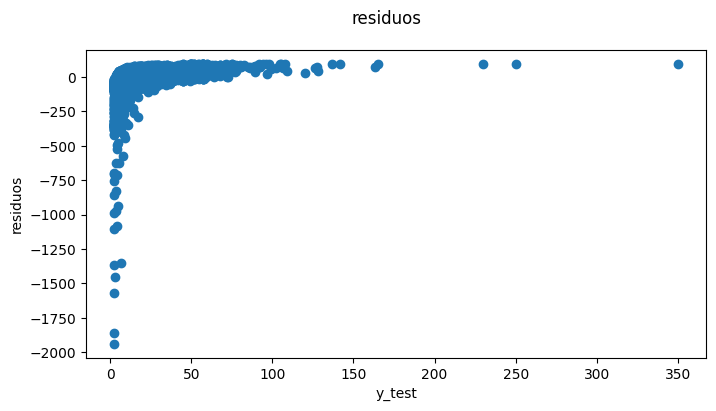

In [107]:
# Residuos

fig = plt.figure(figsize=(8,4))
fig.suptitle('residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test,100*(y_test-y_pred)/y_test)
plt.show()

In [108]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


x_train shape: (159982, 13)
y_train shape: (159982, 1)


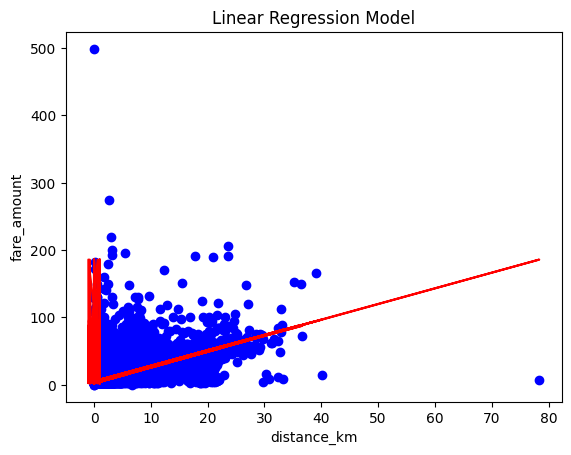

In [109]:
plt.scatter(x_train['distance_km'], y_train, color='blue')
plt.plot(x_train, linear_model.predict(x_train), color='red')

plt.xlabel('distance_km')
plt.ylabel('fare_amount')
plt.title('Linear Regression Model')

plt.show()